<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

### Tutorial For Cellular Automaton Vegetation Model Coupled With Ecohydrologic Model

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="http://nbviewer.ipython.org/github/landlab/tutorials/blob/master/cellular_automaton_vegetation_DEM/cellular_automaton_vegetation_DEM_unexpanded.ipynb">http://nbviewer.ipython.org/github/landlab/tutorials/blob/master/cellular_automaton_vegetation_DEM/cellular_automaton_vegetation_DEM_unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

This tutorial demonstrates implementation of the Cellular Automaton Tree-GRass-Shrub Simulator (CATGRaSS) [Zhou et al., 2013] on a digital elevation model (DEM). This model is built using components from the Landlab component library. CATGRaSS is a spatially explicit model of plant coexistence. It simulates local ecohydrologic dynamics (soil moisture, transpiration, biomass) and spatial evolution of tree, grass, and shrub Plant Functional Types (PFT) driven by rainfall and solar radiation. 

Each cell in the model grid can hold a single PFT or remain empty. Tree and shrub plants disperse seeds to their neighbors. Grass seeds are assumed to be available at each cell. Establishment of plants in empty cells is determined probabilistically based on water stress for each PFT. Plants with lower water stress have higher probability of establishment. Plant mortality is simulated probabilistically as a result of aging and drought stress. Fires and grazing will be added to this model soon.  

This model contains:
- A local vegetation dynamics model that simulates storm and inter-storm water balance and ecohydrologic fluxes (ET, runoff), and plant biomass dynamics. This module is built up of the following components:
    - PrecipitationDistribution
    - Radiation
    - PotentialEvapotranspiration
    - SoilMoisture
    - Vegetation

- A spatially explicit probabilistic cellular automaton component that models plant competition by tracking establishment and mortality of plants based on soil moisture stress. The name of the component is:
    - VegCA
    
To run this IPython notebook, please make sure that the following files are in the same folder:
 - cellular_automaton_vegetation_DEM.ipynb (this notebook)
 - Inputs_Vegetation_CA.txt
 - Ecohyd_functions_DEM.py
    
[Ref: Zhou, X, E. Istanbulluoglu, and E.R. Vivoni. "Modeling the ecohydrological role of aspect-controlled radiation on tree-grass-shrub coexistence in a semiarid climate." Water Resources Research 49.5 (2013): 2872-2895]

#### Let's walk through the code:

Import the required libraries:

In [1]:
import time
import numpy as np
from landlab.io import read_esri_ascii
from landlab import RasterModelGrid as rmg
from Ecohyd_functions_DEM import txt_data_dict, Initialize_, \
                    Empty_arrays, Create_PET_lookup, Save_, Plot_
%matplotlib inline

Note: Ecohyd_functions_DEM contains methods that help keep this driver concise. In practice, all the methods/commands in Ecohyd_functions_DEM can be a part of this driver.

Initialize domain by instantiating two grids:
- grid: We shall simulate cellular automaton vegetation competition coupled with vegetation dynamics on this grid. You can select the dimensions and spacing of the grid. Each cell can be occupied by a single PFT such as tree, shrub, grass, tree seedling/shrub seedling, or can be empty (bare).
- grid1: this grid contains enough cells to represent each PFT (6 cells in our case). This is a representative grid which will be used to compute plant-specific potential evapotranspiration lookup arrays.

In [2]:
(grid,elevation) = read_esri_ascii('DEM_10m.asc') # Read the DEM
grid1 = rmg(5,4,5)   # Representative grid

Include the input file that contains all input parameters needed for all components. This file can either be a Python dictionary or a text file that can be converted into a Python dictionary.

In [3]:
InputFile = 'Inputs_Vegetation_CA.txt'
data = txt_data_dict( InputFile ) # Create dictionary that holds the inputs

Instantiate Landlab components to simulate corresponding attributes. In this example, we shall demonstrate the use of seasonal rainfall and PFT-specific potential evapotranspiration. The instantiated objects are:
- PD_D: object for dry season rainfall, 
- PD_W: object for wet season rainfall, 
- Rad: Radiation object computes radiation factor defined as the ratio of total shortwave radiation incident on a sloped surface to total shortwave radiation incident on a flat surface. 
- Rad_PET: Representative radiation object which is used only as an input for PET.
- PET_PFT: Plant specific PET objects (we use a cosine function to represent Penman Monteith PET as a function of Day Of the Year (DOY) to reduce computation overhead). This value is spatially distributed by using a radiation factor.
- SM: Soil Moisture object simulates root-zone average soil moisture at each cell using inputs of potential evapotranspiration, live leaf area index, and vegetation cover.
- VEG: Vegetation dynamics object simulates net primary productivity and biomass and thus leaf area index at each cell based on inputs of root-zone average soil moisture.
- vegca: Cellular Automaton plant competition object is run once every year. This object is initialized with a random cellular field of PFT. Each year, this object updates the cellular field of PFT based on probabilistic establishment and mortality of PFT at each cell.

Note: Almost every component in Landlab is coded as a 'class' (to harness the advantages of object oriented programming). An 'object' is the instantiation of the 'class' (for more information, please refer any object oriented programming book). A 'field' refers to a Landlab field (please refer to the [Landlab documentation](https://github.com/landlab/landlab/wiki/Grid#adding-data-to-a-landlab-grid-element-using-fields) to learn more about Landlab fields).

In [4]:
PD_D, PD_W, Rad, Rad_PET, PET_Tree, PET_Shrub, PET_Grass, SM, VEG, vegca =    \
                                Initialize_( data, grid, grid1, elevation )

/Users/jennyknuth/anaconda/lib/python2.7/site-packages/landlab/components/vegetation_ca/CA_Veg_new.py:101: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3315 but corresponding boolean dimension is 1085
  VegType[tp[VegType == TREE] < self._tpmax_tr_s] = TREESEEDLING
/Users/jennyknuth/anaconda/lib/python2.7/site-packages/landlab/components/vegetation_ca/CA_Veg_new.py:102: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3315 but corresponding boolean dimension is 584
  VegType[tp[VegType == SHRUB] < self._tpmax_sh_s] = SHRUBSEEDLING


Specify an approximate number of years for the model to run. In the use of 66 below refers to the average number of storms observed in central New Mexico. This number should be changed for different locations.

IMPORTANT: 
This code in numerically extensive. It might take an hour or more to run this simulation for 300 years.

In [5]:
n_years = 50      # Approx number of years for model to run
n = n_years * 66   # Number of storms the model will be run for

Create empty arrays to store spatio-temporal data over multiple iterations. The captured data can be used for plotting model outputs.

In [6]:
P, Tb, Tr, Time, CumWaterStress, VegType, PET_, Rad_Factor, \
                    EP30, PET_threshold = Empty_arrays(n, grid, grid1)

To reduce computational overhead, we shall create a lookup array for plant specific PET values for each day of a year

In [7]:
Create_PET_lookup( Rad, PET_Tree, PET_Shrub, PET_Grass,  PET_, Rad_Factor, \
                        EP30, Rad_PET, grid )

Specify starting time (in years)

In [8]:
## Represent current time in years 
current_time = 0            # Start from first day of Jan
# Keep track of run time for simulation—optional
Start_time = time.clock()     # Recording time taken for simulation
# declaring few buffers used in storm loop
time_check = 0.     # Buffer to store current_time at previous storm
yrs = 0             # Keep track of number of years passed
WS = 0.             # Buffer for Water Stress
Tg = 365        # Growing season in days

The loop below couples the components introduced above in a for loop until all "n" number of storms are generated. Time is advanced by the soil moisture object based on storm and interstorm durations that are estimated by the strom generator object. The ecohydrologic model is run on each storm whereas cellular automaton vegetation component is run once every year.

Note: This loop might take around 10 minutes (depending on your computer) to run for a 50 year simulation.

In [9]:
## Run storm Loop
for i in range(0, n):
    # Update objects
    Julian = np.floor( (current_time - np.floor( current_time )) * 365.)
    if Julian < 182 or Julian > 273:  # Dry Season
        PD_D.update()
        P[i] = PD_D.storm_depth
        Tr[i] = PD_D.storm_duration
        Tb[i] = PD_D.interstorm_duration
    else:                             # Wet Season—Jul to Sep—NA Monsoon
        PD_W.update()
        P[i] = PD_W.storm_depth
        Tr[i] = PD_W.storm_duration
        Tb[i] = PD_W.interstorm_duration

    grid['cell']['PotentialEvapotranspiration'] =  \
            (np.choose(grid['cell']['VegetationType'],PET_[Julian])) * \
                        Rad_Factor[Julian]
    grid['cell']['PotentialEvapotranspiration30'] =  \
            (np.choose(grid['cell']['VegetationType'],EP30[Julian])) * \
                        Rad_Factor[Julian]
    current_time = SM.update( current_time, P = P[i], Tr = Tr[i], Tb = Tb[i] )
    if Julian != 364:
        if EP30[Julian + 1,0] > EP30[Julian,0]:
            PET_threshold = 1  # 1 corresponds to ETThresholdup
        else:
            PET_threshold = 0  # 0 corresponds to ETThresholddown
    VEG.update(PotentialEvapotranspirationThreshold = PET_threshold)

    WS += (grid['cell']['WaterStress'])*Tb[i]/24.
    Time[i] = current_time

    # Cellular Automata
    if (current_time - time_check) >= 1.:
        VegType[yrs] = grid['cell']['VegetationType']
        CumWaterStress[yrs] = WS/Tg
        grid['cell']['CumulativeWaterStress'] = CumWaterStress[yrs]
        vegca.update()
        SM.initialize(  data, VEGTYPE = grid['cell']['VegetationType'])
        VEG.initialize( data, VEGTYPE = grid['cell']['VegetationType'] )
        time_check = current_time
        WS = 0
        i_check = i
        yrs += 1
VegType[yrs] = grid['cell']['VegetationType']

/Users/jennyknuth/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jennyknuth/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jennyknuth/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jennyknuth/anaconda/lib/python2.7/site-packages/landlab/components/vegetation_ca/CA_Veg_new.py:145: RuntimeWarning: divide by zero encountered in divide
  Peg = np.amin(np.vstack((Phi_g/(n*self._INg),Pemaxg)),axis = 0)


Time_Consumed is an optional variable that gives information about computer running time

In [10]:
Final_time = time.clock()
Time_Consumed = (Final_time - Start_time)/60.    # in minutes

Save the outputs using ``numpy.save``. these files have '.nc' extension, which can be loaded using ``numpy.load``.

In [11]:
## Saving
sim = 'VegCA_DEM_25May15_'
Save_( sim, Tb, Tr, P, VegType, CumWaterStress, yrs, Time_Consumed, Time )

Lets look at outputs.

Plots of the cellular field of PFT at specified year step can be found below where:

GRASS = Green;  SHRUB = Red;  TREE = Black;  BARE = White;

At the end, percentage cover for each PFT is plotted with respect to time.

Plotting cellular field of Plant Functional Type
Green - Grass; Red - Shrubs; Black - Trees; White - Bare


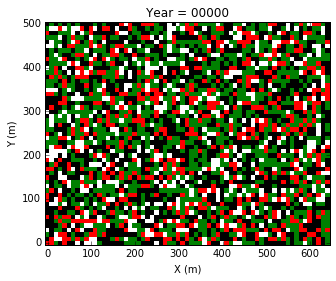

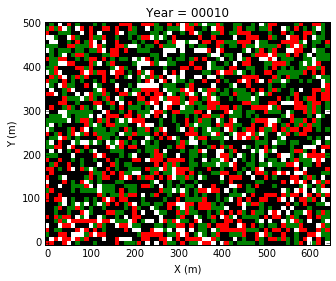

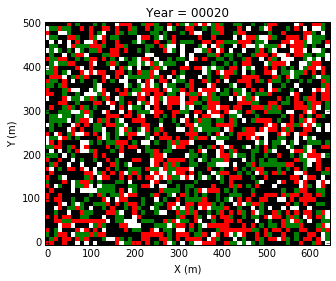

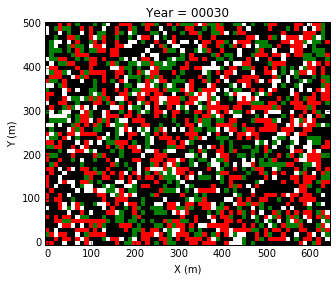

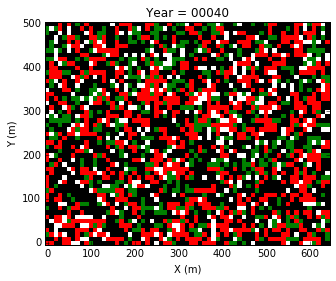

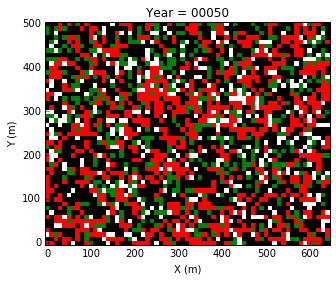

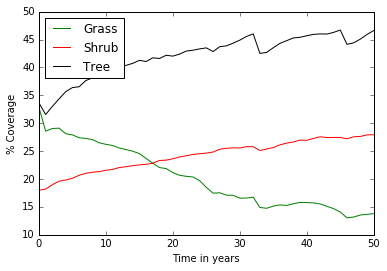

In [12]:
Plot_( grid, VegType, yrs, yr_step=10 )

#### If you run this model for around 900 years, you will observe patterns of PFTs. For example, you will find more trees on north facing slopes and mostly shrubs and grass on south facing slopes, as shown below:

[Errno 2] No such file or directory: 'long_sim_images'
/Users/jennyknuth/Landlab/tutorials/ecohydrology/cellular_automaton_vegetation_DEM


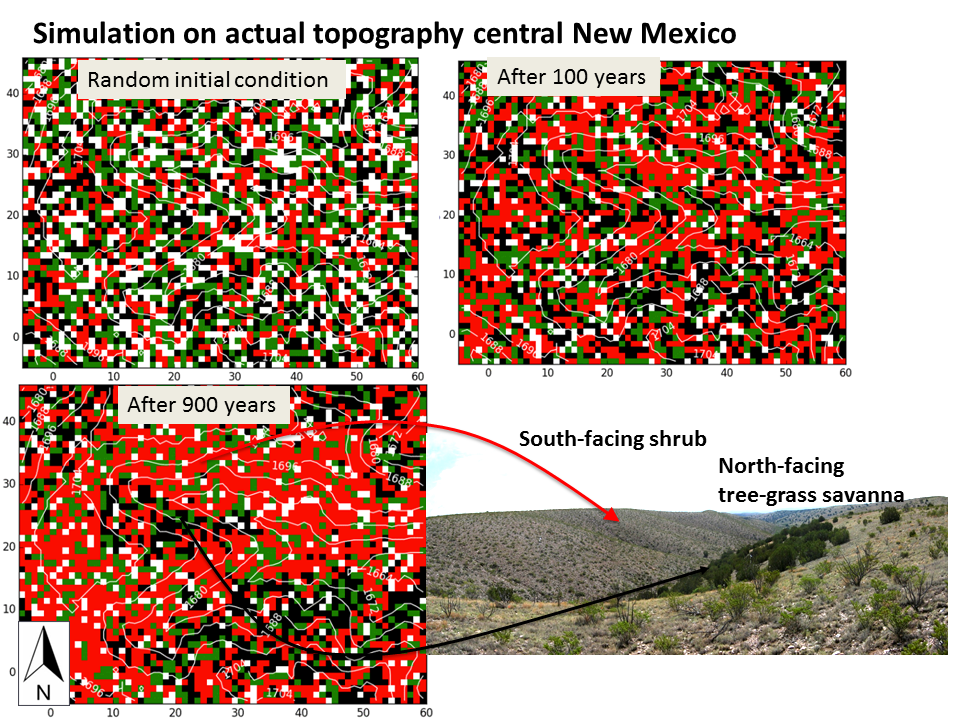

In [13]:
%cd long_sim_images
from IPython.display import Image
Image(filename = 'presentation.png')

In [14]:
%cd ..

/Users/jennyknuth/Landlab/tutorials/ecohydrology


### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>